Asynchronous class 19: April 7, 2021
============================

Today it's time to extend our waves to a much more interesting system: the coupled acoustic/gravity wave system of the atmosphere.

# Homework
No written homework.  Instead, read two things this week.
1. Kataoka et al 2017, "Tilting at wave beams: a new perspective on the St. Andrew’s Cross"
2. Chandrasekhar chapter 1

# Lecture

Today's lecture is a second worked-exercise in python with `sympy` and follows below.

This notebook introduces you to using `sympy` as tool for solving linear systems.  Here, we construct a linear system for compressible waves, including both acoustic and gravity waves and then use the determinant method to solve for the wave dispersion relationship.

To install sympy, run this command:

`pip install sympy` 

at your command prompt.  The `jupyterlab` are RC computing now also has `sympy` installed, and you should be able to edit and work on the notebook with your name there, if preferred.  There it should be visible under `ASTR_5400/lectures/AS19`.  If you do this, when you're done, right click on your file, select "download", and then upload that to Canvas.


Linear waves in an Isothermal atmosphere.
==========

We've solved two constant coefficient wave systems: acoustic waves in a isothermal, isodensity atmosphere using the fully compressible equations, and internal gravity waves in the Boussinesq approximation for an atmosphere with a temperature gradient.

If we consider the fully compressible equations in an appropriate atmosphere, we might ask whether there is a system that has both acoustic and gravity waves.  The answer is yes, for a stably-stratified atmosphere.  We'll learn that this is an atmosphere where the entropy gradient is positive.  The entropy gradient in an ideal gas is:
\begin{align}
\vec{\nabla} \frac{s}{c_P} = \frac{1}{\gamma}\vec{\nabla}\ln T - \frac{\gamma-1}{\gamma}\vec{\nabla}\ln \rho,
\end{align}
where $c_P$ is the specific heat at constant pressure and $s$ is the specific entropy.  This can be derived from the equation of state:
\begin{align}
\frac{s}{c_P} = \ln\left(\frac{P^{1/\gamma}}{\rho}\right).
\end{align}
But that's all an aside.  Here we solve for the linear acoustic-gravity waves themselves.

The linear system we are solving is:
\begin{gather}
\frac{\partial}{\partial t} \vec{u} + \vec{\nabla}R T_1 + R T_1 \vec{\nabla}\ln \rho_0 + R T_0 \vec{\nabla}\ln \rho_1  = 0 \\
\frac{\partial}{\partial t} T + (\gamma-1)T_0\vec{\nabla}\cdot\vec{u} + \vec{u}\cdot\vec{\nabla} T_0 = 0 \\
\frac{\partial}{\partial t} \ln \rho_1 +  \vec{\nabla}\cdot\vec{u} +  \vec{u}\cdot\vec{\nabla} \ln\rho_0 = 0
\end{gather}
or in component form:
\begin{align}
\frac{\partial}{\partial t} w &+ \frac{\partial}{\partial z} R T_1 + R T_1 \nabla \ln \rho_0 + R T_0 \frac{\partial}{\partial z}\ln \rho_1 = 0 \\
\frac{\partial}{\partial t} u &+ \frac{\partial}{\partial x}  R T_1 + R T_0 \frac{\partial}{\partial x}\ln \rho_1 = 0 \\
\frac{\partial}{\partial t} T &+ w\nabla T_0 + (\gamma-1)T_0\left(\frac{\partial}{\partial z} w + \frac{\partial}{\partial x} u\right) = 0 \\
\frac{\partial}{\partial t} \ln \rho_1 &+ w\nabla \ln\rho_0 + \left(\frac{\partial}{\partial z} w + \frac{\partial}{\partial x} u \right) = 0
\end{align}

This is an analytically tractable system, given the tools you currently have, if it's a constant coefficient atmosphere.  This occurs for the "Isothermal Atmosphere", where:
\begin{align}
    T_0 = C_1, \quad \nabla T_0 = 0, \quad  \nabla \ln\rho_0 = C_2,
\end{align}
with $C_1$ and $C_2$ constants.  We set $C_1=T_0$, while $C_2$ is:
\begin{align}
    C_2 = \frac{-1}{H} = \nabla \ln\rho_0
\end{align}
where $H$ is the density scale-height.  This should all look familiar from the beginning of the course.  With constant $\gamma$ and $R$, this yields a constant coefficient system.

Our wavelike set of perturbations in time and space are:
\begin{align}
    w,u,T_1,\ln\rho_1 \propto e^{i \omega t}e^{-i m x - i K z}
\end{align}
One thing that is different here is that the vertical wave number $K$ has both an oscillating part and an exponentially growing envelope part:
\begin{align}
K = k + \frac{i}{2H}.
\end{align}
This, it turns out, is required for $\omega$ to be real.  You can read more about this in Section 3 of [Brown, Vasil & Zweibel (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...756..109B/abstract) if you're interested.

The resulting fluctuating equations are for quantity $q$ are:
\begin{align}
    \frac{\partial}{\partial t} q \rightarrow i \omega q \qquad \text{and} \qquad 
    \vec{\nabla} q \rightarrow \left(-i m \vec{\hat{x}} -i \left(k + \frac{i}{2H}\right) \vec{\hat{z}}\right) q 
\end{align}

In [1]:
import sympy as sym
sym.init_printing()

In [2]:
ω = sym.symbols('ω', real=True)
m, k, K= sym.symbols('m, k, K', real=True)
γ, R, T0 = sym.symbols('γ, R, T0', real=True, positive=True)
grad_T0, grad_ln_ρ0 = sym.symbols('∇T_0, ∇lnρ_0', real=True, negative=True)
cs2, N, H= sym.symbols('c_s^2, N, H', real=True, positive=True, nonzero=True, finite=True)
p = sym.symbols('p', postive=True)
i = sym.I

In sympy, we first construct the general isothermal FC matrix `A_gen`, and then make substitutions to make a form of `A` that is simpler to understand:

In [3]:
A_gen = sym.Matrix([[ i*ω,                             0, -R*i*K+R*grad_ln_ρ0, -R*T0*i*K],
                    [   0,                           i*ω,              -R*i*m, -R*T0*i*m],
                    [grad_T0-i*K*(γ-1)*T0, -i*m*(γ-1)*T0,                 i*ω,         0],
                    [grad_ln_ρ0-i*K,                -i*m,                   0,       i*ω]])
# apply isothermal atmosphere asumption, and enveloped wave stucture in z
A = A_gen.subs(((K, k+i/(2*H)),(grad_ln_ρ0, -1/H),(grad_T0,0)))
display(A)

⎡                                                ⎛     ⅈ ⎞   R          ⎛     
⎢          ⅈ⋅ω                   0         - ⅈ⋅R⋅⎜k + ───⎟ - ─  -ⅈ⋅R⋅T₀⋅⎜k + ─
⎢                                                ⎝    2⋅H⎠   H          ⎝    2
⎢                                                                             
⎢           0                   ⅈ⋅ω              -ⅈ⋅R⋅m             -ⅈ⋅R⋅T₀⋅m 
⎢                                                                             
⎢      ⎛     ⅈ ⎞                                                              
⎢-ⅈ⋅T₀⋅⎜k + ───⎟⋅(γ - 1)  -ⅈ⋅T₀⋅m⋅(γ - 1)          ⅈ⋅ω                  0     
⎢      ⎝    2⋅H⎠                                                              
⎢                                                                             
⎢       ⎛     ⅈ ⎞   1                                                         
⎢   - ⅈ⋅⎜k + ───⎟ - ─          -ⅈ⋅m                 0                  ⅈ⋅ω    
⎣       ⎝    2⋅H⎠   H                               

This system `A` has dispersion relationship:
\begin{align}
-\frac{ω^{4}}{c^{2}_{s}} + ω^{2} \left(k^{2} + m^{2} + \frac{1}{4 H^{2}}\right)  = N^{2} m^{2}\end{align}
where
\begin{align}
N^{2} = -\vec{g}\cdot\vec{\nabla}\left(\frac{s}{c_P}\right) = \frac{\gamma}{\gamma-1}\frac{g}{H}.
\end{align}
is the Brunt-Vaisalla frequency of the atmosphere and where
\begin{align}
    c^2_s = \gamma R T_0
\end{align}
is the adiabatic sound speed.  This is the speed of sound waves that propagate adiabatically, without thermal diffusion between them and the atmosphere.

The raw determinant of this system is a mess and not very informative:

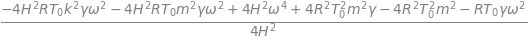

In [4]:
A.det()

The skill and magic of using tools like `sympy` (or Mathematica) is to manipulate the expresions until they turn into a useful form. 

The code below uses `sympy` solve for this dispersion relationship given the matrix A, with clever substitutions, and it then uses expansion and collection tricks to simplify the resulting expression.

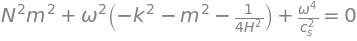

In [5]:
dispersion = sym.collect(sym.collect(sym.expand(sym.cancel(sym.expand(sym.collect(sym.collect(sym.expand(A.det()/cs2), ω).subs(γ*R*T0, cs2), cs2).subs(R*T0/H**2, γ/(γ-1)*N**2).subs(γ*R*T0,cs2)).subs(γ, p + 1))), N), ω)
system = sym.Eq(dispersion,0)
display(system)

The nice version of this is:
\begin{align}
-\frac{ω^{4}}{c^{2}_{s}} + ω^{2} \left(k^{2} + m^{2} + \frac{1}{4 H^{2}}\right)  = N^{2} m^{2}
\end{align}

Note that this system is now fourth-order in $\omega$.  This means that there are two solutions for $\omega^2$ (it's a quadratic equation for $\omega^2$). One corresponds to the acoustic wave branch, while one corresponds to the internal gravity wave branch within this atmosphere.

We're going to spend some time playing with this system and learning from it.

## Some magic tricks 
One way we can clean this up further is to introduce two special frequencies:
\begin{align}
\omega^2_{A} = c^2_s \left(k^2 + m^2 + + \frac{1}{4 H^{2}}\right) \\
\omega^2_{G} = N^2 \left(\frac{m^2}{k^2 + m^2 + \frac{1}{4 H^{2}}}\right)
\end{align}
These are the limiting characteristic frequencies of acoustic and gravity waves respectively in this isothermal atmosphere.  Here's how we can do a solution in `sympy` showing this:

here's a sympy solution for the same:


with two solutions for $\omega^2$


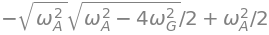

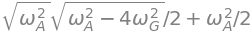

In [6]:
ω_A2, ω_G2 = sym.symbols('ω_{A}^2, ω_{G}^2', positive=True, real=True)
K_full2 = sym.symbols('K^2_{\mathrm{full}}', real=True)
#K_full2 = k**2+m**2+1/(4*H**2)
#ω_A2 = cs2*K_full2
#ω_G2 = N**2*m**2/K_full2
print("here's a sympy solution for the same:")
cs2_dispersion = sym.factor(cs2*dispersion.subs(k**2,K_full2-m**2-1/(4*H**2)).subs(N**2,ω_G2/m**2*K_full2).subs(K_full2,ω_A2/cs2))
new_system = sym.Eq(cs2_dispersion,0)
display(new_system)
solns = sym.solveset(new_system, ω**2)
print("with two solutions for $\omega^2$")
for soln in solns:
    display(soln)

That's how we can solve this in `sympy`.  Now let's make some plots.

## Plotting `sympy`
To plot `sympy` expressions, we need to do some clever things to discretize the continous solution.  Here we do that using the `sympy.lamdify` functions to parse `numpy` arrays, and then use `matplotlib` to plot out the dispersion relationships.

Text(0.5, 0, '$m$')

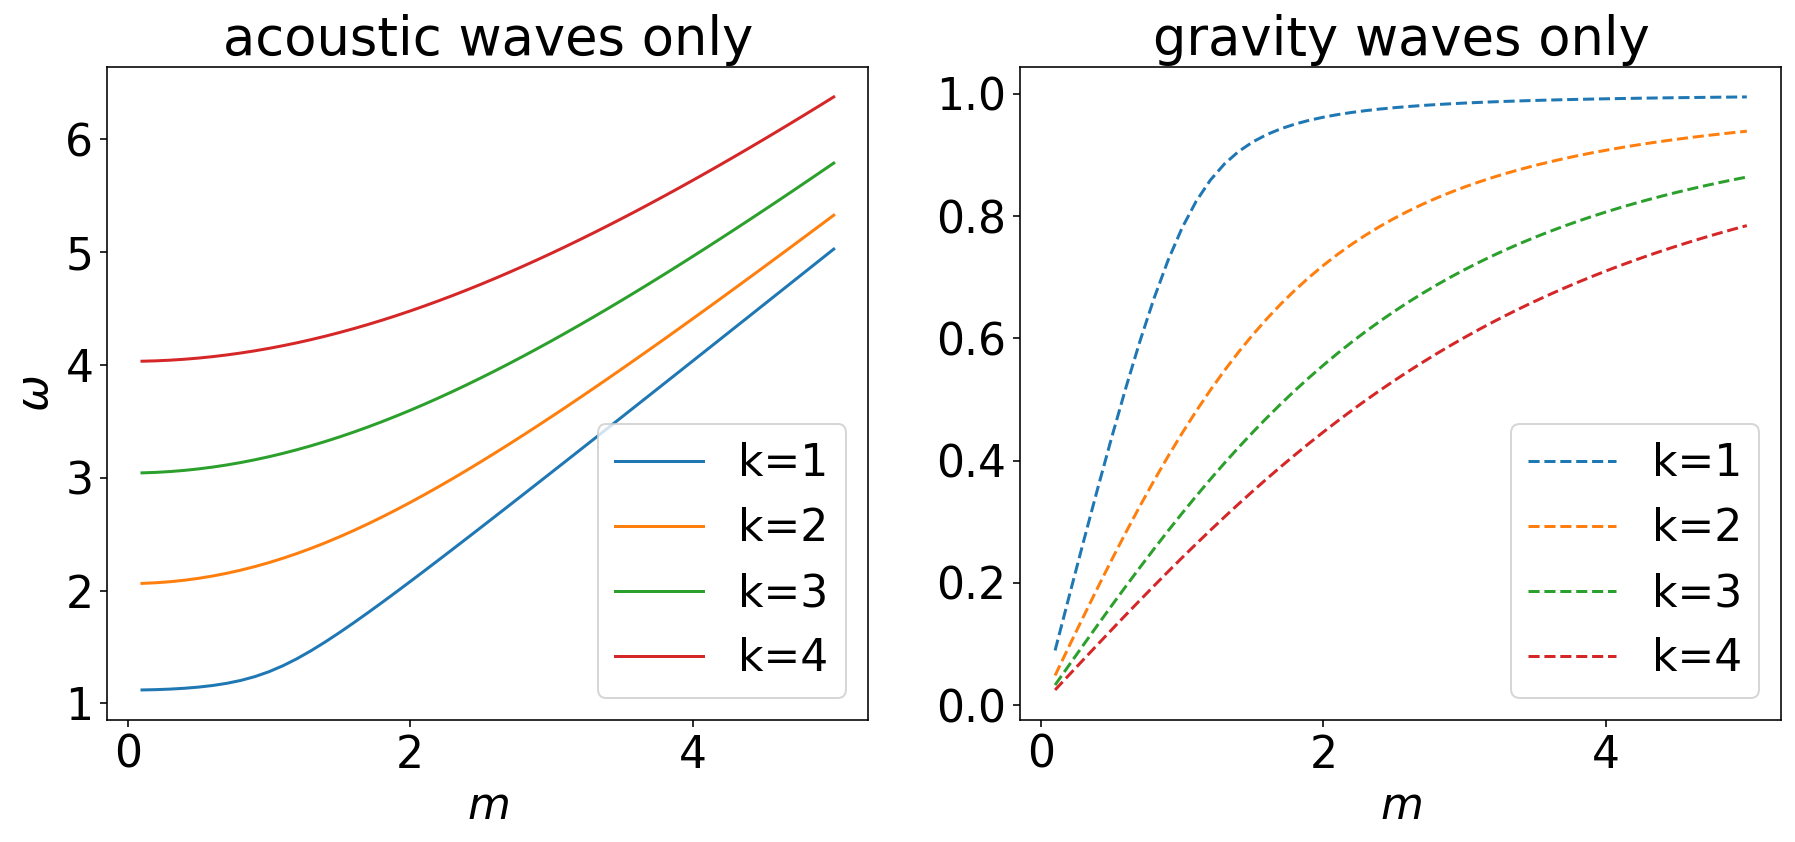

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(ncols=2, figsize=[15,6])

omega2_acoustic = sym.lambdify([m,k],solns.args[1].subs(ω_A2, cs2*K_full2).subs(ω_G2,N**2*m**2/K_full2).subs(cs2,1).subs(N,1).subs(K_full2, k**2+m**2+1/(4*H**2)).subs(H,1),"numpy")
omega2_gravity = sym.lambdify([m,k],solns.args[0].subs(ω_A2, cs2*K_full2).subs(ω_G2,N**2*m**2/K_full2).subs(cs2,1).subs(N,1).subs(K_full2, k**2+m**2+1/(4*H**2)).subs(H,1),"numpy")

ms = np.linspace(0.1,5)
ks = np.arange(1,5)
for k_i in ks:
    ax[0].plot(ms, np.sqrt(omega2_acoustic(ms, k_i)), label='k={:}'.format(k_i))
    
for k_i in ks:
    ax[1].plot(ms, np.sqrt(omega2_gravity(ms, k_i)), label='k={:}'.format(k_i), linestyle='dashed')
    
ax[0].legend()
ax[0].set_title("acoustic waves only")
ax[1].legend()
ax[1].set_title("gravity waves only")
ax[0].set_ylabel(r'$\omega$')
ax[0].set_xlabel(r'$m$')
ax[1].set_xlabel(r'$m$')

Above are plots of the acoustic branch (left) and the gravity wave branch (right) separately.  Linestyles here follow their usage in the diagrams below.

Next, we plot them together.

<ipython-input-8-8db605e67f1a>:7: RuntimeWarning: invalid value encountered in sqrt
  ax[0].plot(ms, np.sqrt(omega2_gravity(ms, k_i)), color=ac[0].get_color(), linestyle='dashed')


Text(0.5, 0, '$m$')

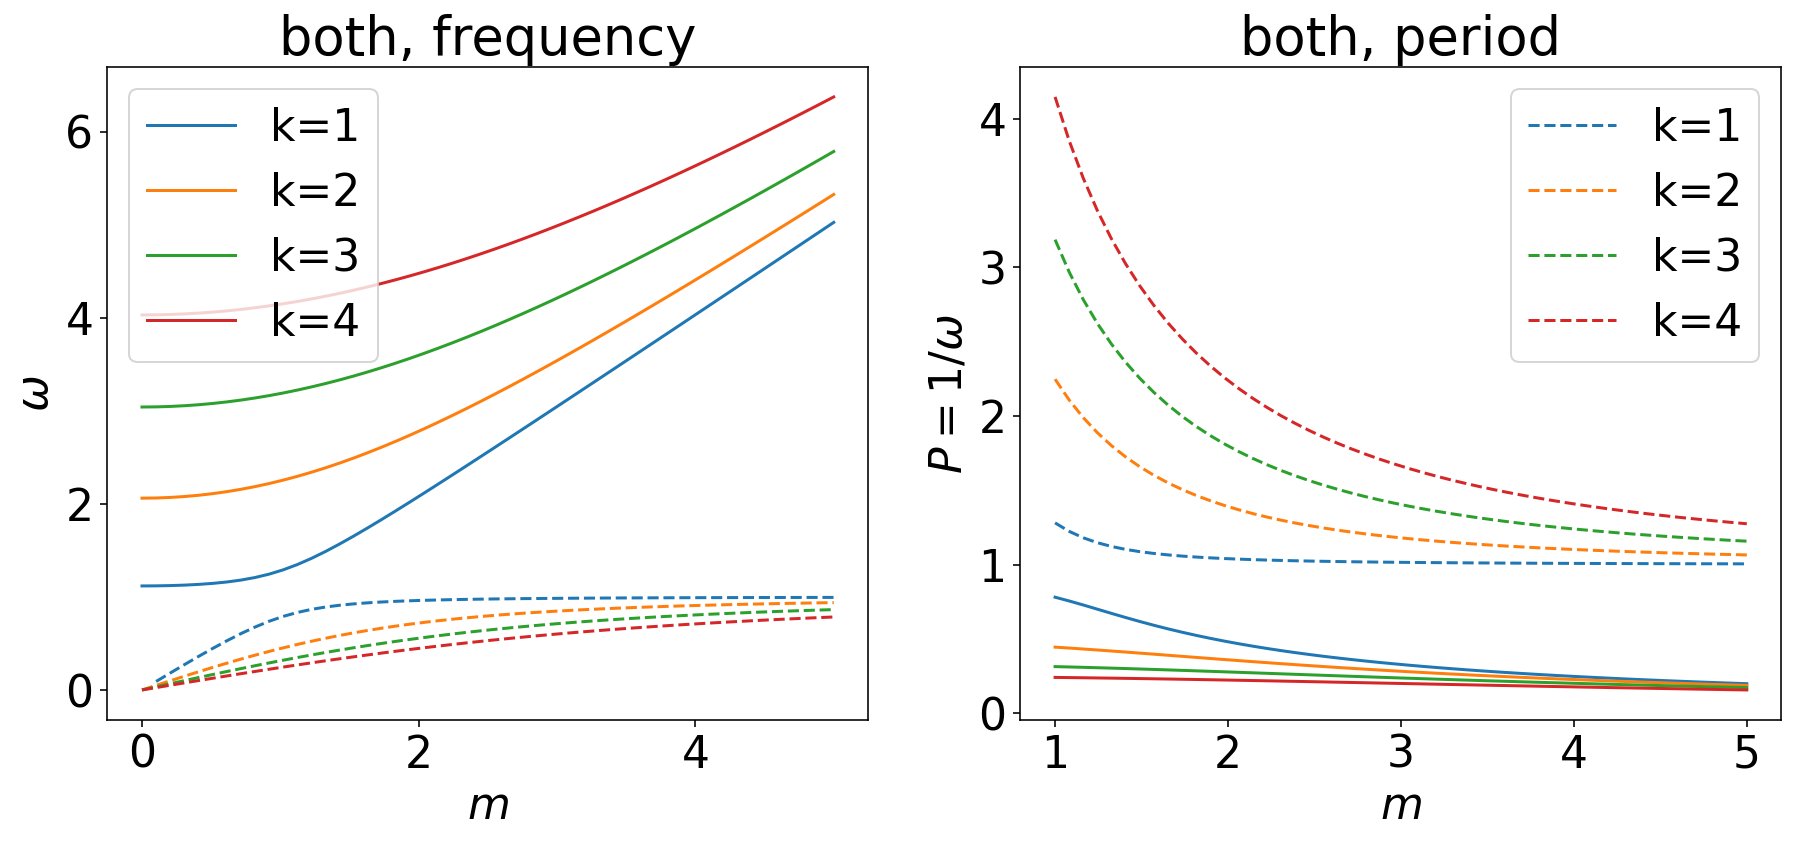

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=[15,6])

ms = np.linspace(0,5)
ks = np.arange(1,5)
for k_i in ks:
    ac = ax[0].plot(ms, np.sqrt(omega2_acoustic(ms, k_i)), label='k={:}'.format(k_i))
    ax[0].plot(ms, np.sqrt(omega2_gravity(ms, k_i)), color=ac[0].get_color(), linestyle='dashed')

ms = np.linspace(1,5)
for k_i in ks:
    ac = ax[1].plot(ms, 1/np.sqrt(omega2_acoustic(ms, k_i)))
    ax[1].plot(ms, 1/np.sqrt(omega2_gravity(ms, k_i)), label='k={:}'.format(k_i), color=ac[0].get_color(), linestyle='dashed')

ax[0].legend()
ax[0].set_title("both, frequency")
ax[1].legend()
ax[1].set_title("both, period")
ax[0].set_ylabel(r'$\omega$')
ax[0].set_xlabel(r'$m$')
ax[1].set_ylabel(r'$P=1/\omega$')
ax[1].set_xlabel(r'$m$')

We've shown two views of the combined dispersion relationship.  At left is a frequency diagram, while at right is a period diagram, where $P=1/\omega$.  Remember that dashed lines in both diagrams give the the gravity wave branch, while solid lines give the acoustic branch.  Lines with the same color are the same vertical wavenumber $k$.  

Periodograms are useful when studying internal gravity waves, while frequency diagrams (which you're likely more familiar with, from Fourier analysis) are useful when studying acoustic waves.  We'll learn a little bit about why below.

# Participation

We've done a lot of things above.  Here we do some small exercises on these acoustic/internal gravity waves to check our work above.  I expect you to use this notebook and `sympy` to calculate the determinants, derivatives, etc. required below.  You could do them by hand, or using Mathematica or other tools, but it's useful to learn how to use this machinery.  You will do a pencil and paper test in Q1 and Q2.  For Q3, copy the plotting blocks above and implement any changes you need to illustrate what you want to show.

$\renewcommand{\vec}{\boldsymbol}$
$\renewcommand{\del}{\vec{\nabla}}$

1. Show that by introducing the frequencies $\omega_A$ and $\omega_G$ we can simplify the dispersion relationship to:
\begin{align}
    -\omega^4 + \omega^2_A \omega^2 = \omega^2_A \omega^2_G
\end{align}
We do it with sympy above.  Here I'd like you to work it out on pencil and paper.  Enter your answer here using markdown/latex, and show your work.

2. Use the quadratic formula and pencil and paper to solve for the two branches of $\omega^2$.  If you don't remember how to do this, see [this Wikipedia page](https://en.wikipedia.org/wiki/Quadratic_equation).  I remember this by singing a little song.  Write up your pencil-and-paper solution here in markdown/latex.

   Above I've done this via `sympy` and using some tricks.  Check that your results agree, and then continue to the last part.
    
3. Time to do some plotting and interpretation.  Above in this notebook are a bunch of magic words that make plots of the acoustic and gravity waves, individually and then together.  Play with those plots (see bottom where I've replicated it) to answer these questions, using plots you generate to illustrate your points:
  - Plot $\omega_A$ and $\omega_G$ over the top of the dispersion relationships.  What can you say about these in relationship to the families of waves?
  - In the limit of large $m$, what can you say about: 
      - the spacing in frequency of acoustic waves?
      - the spacing in periods of gravity waves?

4.  We can use plots of the dispersion relationships to get a sense of how waves propagate.  Using the "both waves" plots in frequency versus horizontal wavenumber $m$ (above plots), I'd like you to consider the group velocities of the acoustic and gravity wave branches.  You obtain this by considering 
\begin{equation}
\vec{v}_g = \frac{\partial \omega}{\partial m}\vec{\hat{x}} + \frac{\partial \omega}{\partial k}\vec{\hat{z}}
\end{equation}
Here I want you to take that derivative in your mind and estimate vertical and horizontal group velocities by examining the curves at fixed $m$ and fixed $k$ at both large and small $m$ ranges.
   - What are rough (qualitative) horizontal and vertical group velocities for acoustic waves at very low and very large $m$?
   - When might you expect acoustic waves to only transport energy vertically and not horizontally?
   - What are rough (qualitative) horizontal and vertical group velocities for gravity waves at very low and very large $m$?
   - When might you expect gravity waves to only transport energy vertically and not horizontally?
   
  

5. Someone hands you a set of observational data.  Why does a periodogram let you identify internal gravity waves, and what would you look for?

**To Turn in**:
Send Ben your answers to 1-5 via Canvas, uploading to Asynchronous Lecture 19.  You can do that in this ipynb and upload as an ipynb.  You can also export to PDF if you prefer.  Please send by noon, Thursday April 8.

Text(0.5, 0, '$m$')

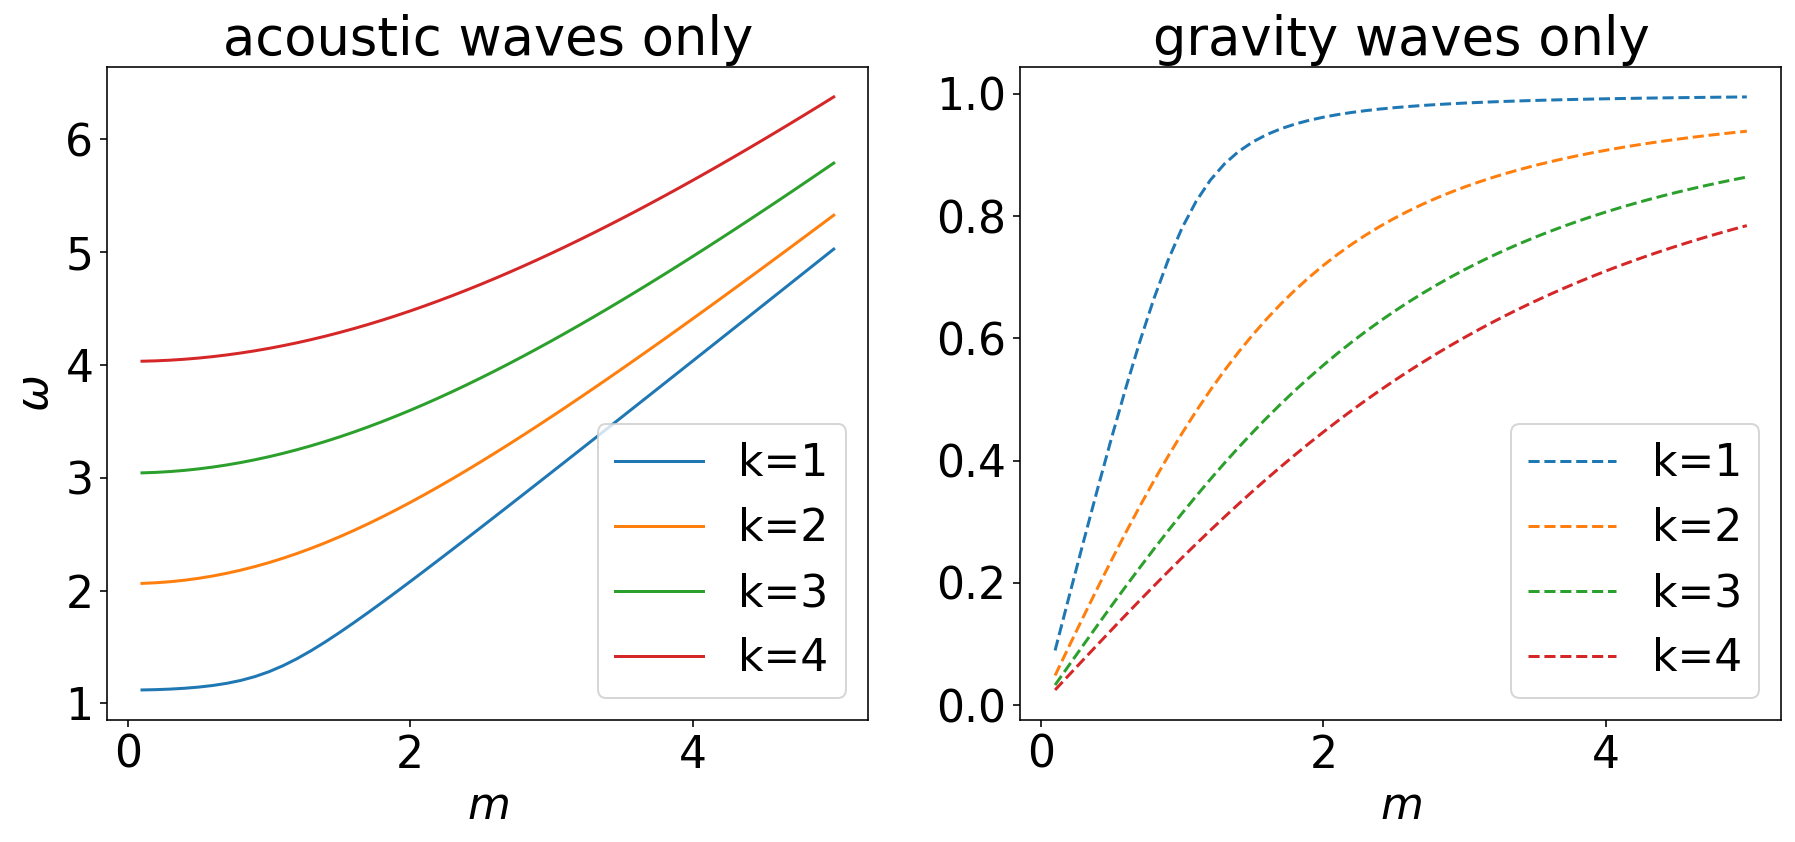

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=[15,6])

omega2_acoustic = sym.lambdify([m,k],solns.args[1].subs(ω_A2, cs2*K_full2).subs(ω_G2,N**2*m**2/K_full2).subs(cs2,1).subs(N,1).subs(K_full2, k**2+m**2+1/(4*H**2)).subs(H,1),"numpy")
omega2_gravity = sym.lambdify([m,k],solns.args[0].subs(ω_A2, cs2*K_full2).subs(ω_G2,N**2*m**2/K_full2).subs(cs2,1).subs(N,1).subs(K_full2, k**2+m**2+1/(4*H**2)).subs(H,1),"numpy")

ms = np.linspace(0.1,5)
ks = np.arange(1,5)
for k_i in ks:
    ax[0].plot(ms, np.sqrt(omega2_acoustic(ms, k_i)), label='k={:}'.format(k_i))
    
for k_i in ks:
    ax[1].plot(ms, np.sqrt(omega2_gravity(ms, k_i)), label='k={:}'.format(k_i), linestyle='dashed')
    
ax[0].legend()
ax[0].set_title("acoustic waves only")
ax[1].legend()
ax[1].set_title("gravity waves only")
ax[0].set_ylabel(r'$\omega$')
ax[0].set_xlabel(r'$m$')
ax[1].set_xlabel(r'$m$')

<ipython-input-10-8db605e67f1a>:7: RuntimeWarning: invalid value encountered in sqrt
  ax[0].plot(ms, np.sqrt(omega2_gravity(ms, k_i)), color=ac[0].get_color(), linestyle='dashed')


Text(0.5, 0, '$m$')

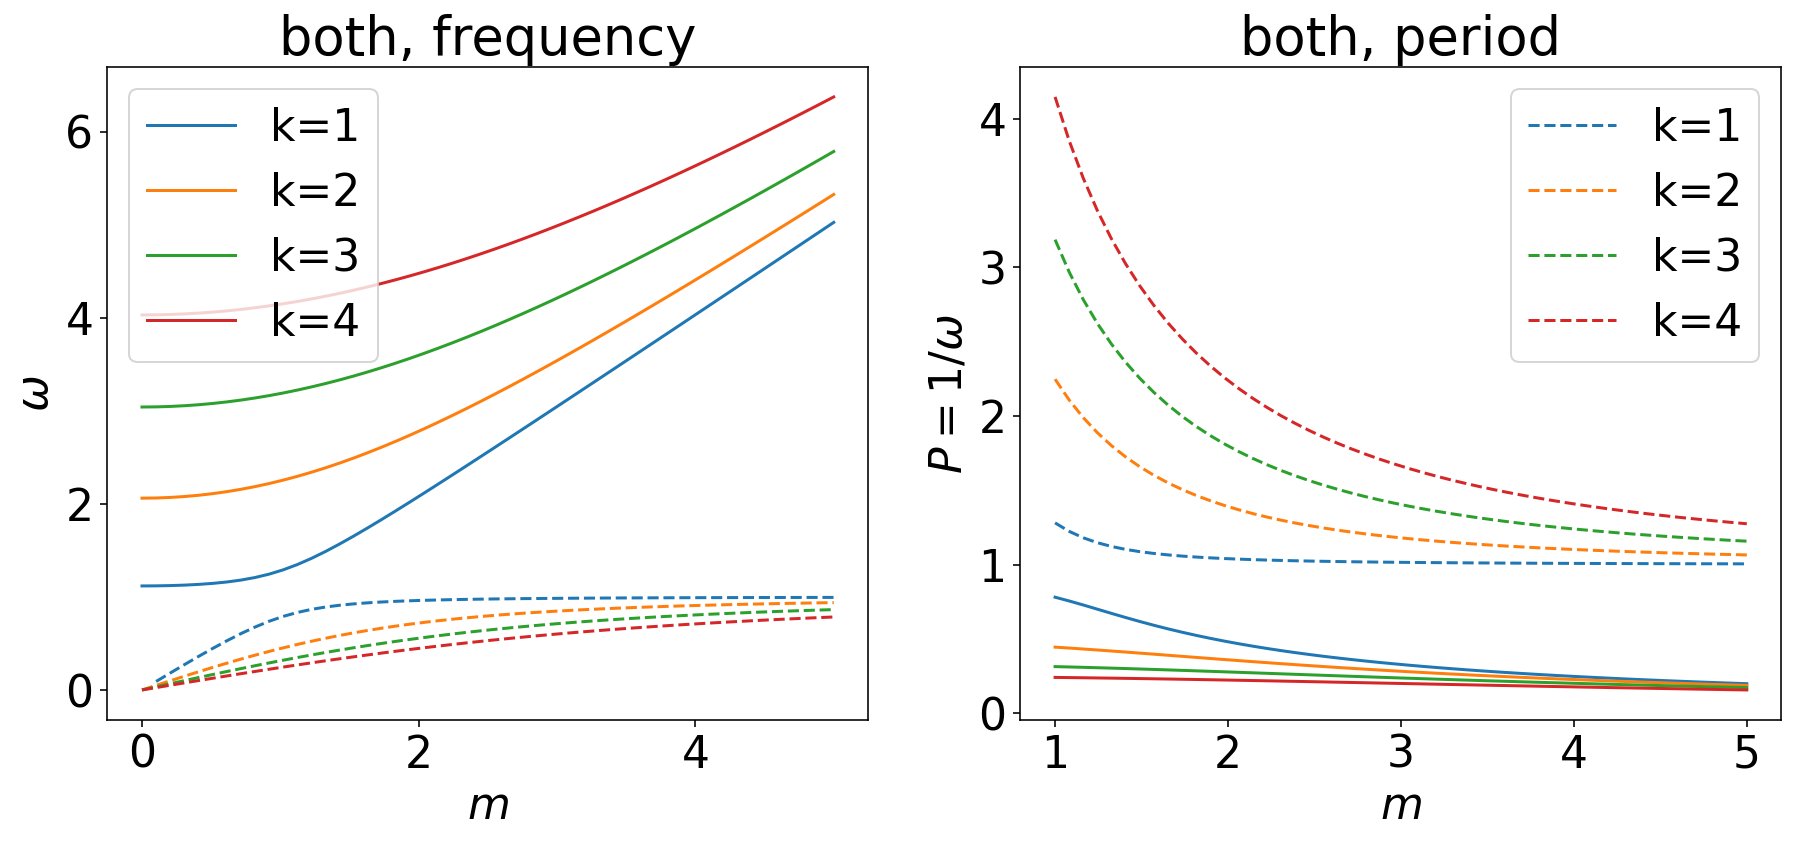

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=[15,6])

ms = np.linspace(0,5)
ks = np.arange(1,5)
for k_i in ks:
    ac = ax[0].plot(ms, np.sqrt(omega2_acoustic(ms, k_i)), label='k={:}'.format(k_i))
    ax[0].plot(ms, np.sqrt(omega2_gravity(ms, k_i)), color=ac[0].get_color(), linestyle='dashed')

ms = np.linspace(1,5)
for k_i in ks:
    ac = ax[1].plot(ms, 1/np.sqrt(omega2_acoustic(ms, k_i)))
    ax[1].plot(ms, 1/np.sqrt(omega2_gravity(ms, k_i)), label='k={:}'.format(k_i), color=ac[0].get_color(), linestyle='dashed')

ax[0].legend()
ax[0].set_title("both, frequency")
ax[1].legend()
ax[1].set_title("both, period")
ax[0].set_ylabel(r'$\omega$')
ax[0].set_xlabel(r'$m$')
ax[1].set_ylabel(r'$P=1/\omega$')
ax[1].set_xlabel(r'$m$')